In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam


2025-04-18 21:28:40.313669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-18 21:28:40.822434: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 21:28:42.670747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/senthil_kmp/miniconda3/envs/tf/lib/
2025-04-18 21:28:42.671387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_

In [2]:
df = pd.read_csv("product-sales.csv", parse_dates=["Date"])
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"])

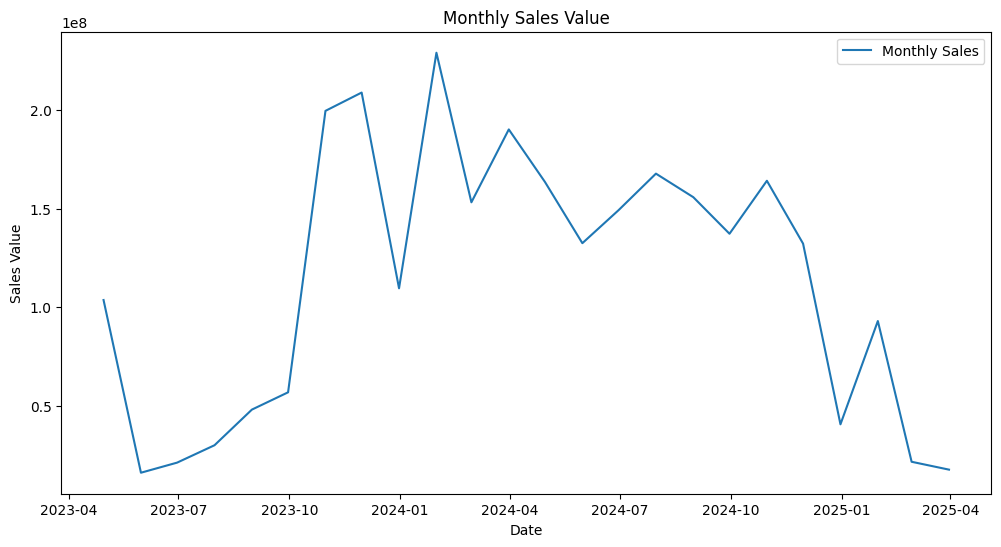

In [3]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Calculate the Sales Value (Amount)
df['SalesValue'] = df['Qty'] * df['Rate']  # Sales value = Quantity * Rate

# Group by month and aggregate the sales data by summing up the sales value
df_monthly = df.groupby(pd.Grouper(key='Date', freq='M')).agg({'SalesValue': 'sum'}).reset_index()

# Plot the monthly sales data to visualize the trend
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['Date'], df_monthly['SalesValue'], label='Monthly Sales')
plt.title('Monthly Sales Value')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.show()



In [4]:
# Scaling the sales data to [0, 1] using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['Scaled_Sales'] = scaler.fit_transform(df['SalesValue'].values.reshape(-1, 1))

# Prepare the time series data (create sequences)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Sequence length (how many previous months to use to predict the next day)
SEQ_LENGTH = 5 # Using the previous 5 months to predict the next day's sales
X, y = create_sequences(df['Scaled_Sales'].values, SEQ_LENGTH)



In [5]:
# Reshape X for RNN input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [6]:
# Build the RNN model
model = Sequential()

# Add a SimpleRNN layer with 50 units and return sequences for possible future layers
model.add(SimpleRNN(units=10, activation='relu', input_shape=(SEQ_LENGTH, 1)))

# Add a Dense layer to output the prediction (1 output for next day's sales)
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='mean_squared_error')
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


2025-04-18 21:28:45.664261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-18 21:28:45.680392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-18 21:28:45.681243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-18 21:28:45.683625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/30
1250/1250 [==============================] - 14s 9ms/step - loss: 0.2033 - val_loss: 0.1712
Epoch 2/30
1250/1250 [==============================] - 8s 6ms/step - loss: 0.1434 - val_loss: 0.1195
Epoch 3/30
1250/1250 [==============================] - 8s 6ms/step - loss: 0.1014 - val_loss: 0.0861
Epoch 4/30
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0766 - val_loss: 0.0683
Epoch 5/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0644 - val_loss: 0.0599
Epoch 6/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0580 - val_loss: 0.0549
Epoch 7/30
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0536 - val_loss: 0.0510
Epoch 8/30
1250/1250 [==============================] - 8s 7ms/step - loss: 0.0503 - val_loss: 0.0481
Epoch 9/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0478 - val_loss: 0.0459
Epoch 10/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.04

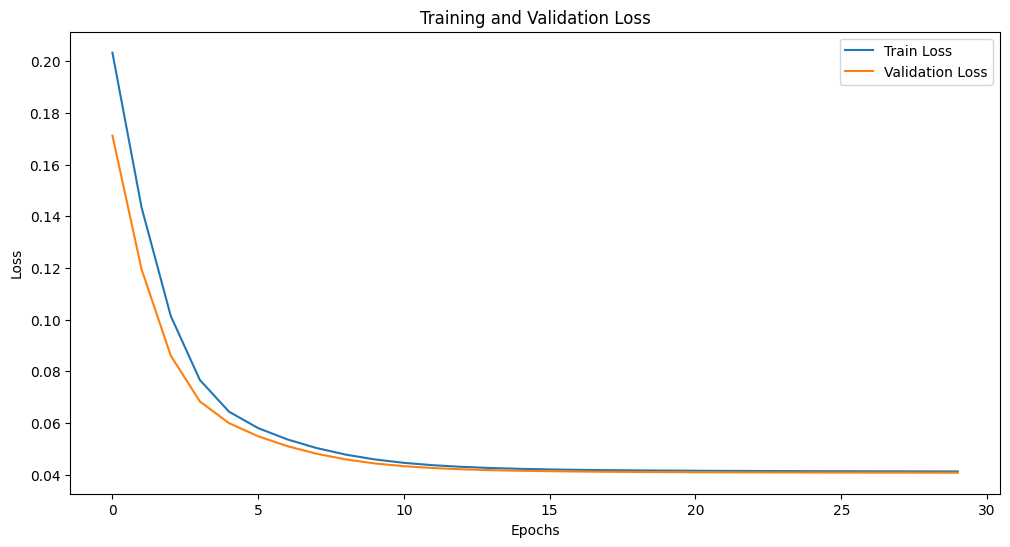

In [7]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


313/313 [==============================] - 2s 5ms/step
Mean Absolute Error (MAE): 38940.21398781254
Root Mean Squared Error (RMSE): 48066.56508891813
MAPE: 291.3345973448671%


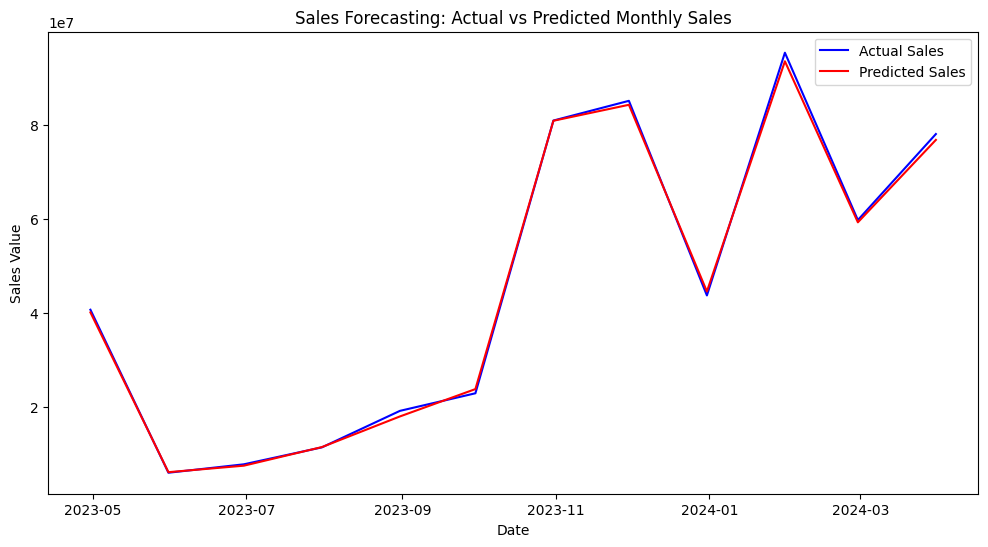

In [8]:
# Predicting the sales for the test set
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values back to original scale
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model's performance
mae = mean_absolute_error(y_test_actual, predictions)
rmse_value = np.sqrt(mean_squared_error(y_test_actual, predictions))
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse_value}')
print(f"MAPE: {mape}%")

# Aggregate the actual sales and predicted sales by month
df_test = df.iloc[-len(y_test):]  # Select the test set portion of the dataframe

# Create a temporary dataframe for predicted values (matching with actual sales dates)
predicted_df = pd.DataFrame({
    'Date': df_test['Date'].values,
    'Predicted_Sales': predictions.flatten()  # Flattening predictions if they are in a 2D array
})

# Aggregate both actual and predicted sales by month
actual_monthly = df_test.groupby(pd.Grouper(key='Date', freq='M')).agg({'SalesValue': 'sum'}).reset_index()
predicted_monthly = predicted_df.groupby(pd.Grouper(key='Date', freq='M')).agg({'Predicted_Sales': 'sum'}).reset_index()

# Plot the monthly actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(actual_monthly['Date'], actual_monthly['SalesValue'], label='Actual Sales', color='blue')
plt.plot(predicted_monthly['Date'], predicted_monthly['Predicted_Sales'], label='Predicted Sales', color='red')
plt.title('Sales Forecasting: Actual vs Predicted Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.show()



In [9]:
import joblib
from tensorflow.keras.models import load_model

# Save the trained model
model.save("rnn_sales_model.h5")

# Save the scaler
joblib.dump(scaler, "sales_scaler.pkl")

# Optionally, save the sequence length to a JSON or text file
import json
metadata = {
    "sequence_length": SEQ_LENGTH
}
with open("model_metadata.json", "w") as f:
    json.dump(metadata, f)

print("Model, scaler, and metadata saved successfully.")


Model, scaler, and metadata saved successfully.
